In [10]:
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, FK5
from astropy.coordinates import AltAz
import numpy as np
import matplotlib.pyplot as plt

f = open("simulated_sources.ascii", "r")
f.readline()
f.readline()
f.readline()
f.readline()
f.readline()
f.readline()

Ra1=[]
Dec1=[]

for line in f:
    if 'nan'in line:
        continue
    ra = line.strip().split()[2]
    Ra1.append(float(ra))
    dec = line.strip().split()[4]
    Dec1.append(float(dec))


Ra_ACE=[]
Dec_ACE=[]
myf=open("ACE_source.txt")
myf.readline()
myf.readline()
myf.readline()

for line in myf:
    ra = line.strip().split()[2].replace(":"," ").replace(",", " ")
    dec = line.strip().split()[3].replace(".", " ", 2).replace(",", " ")
    mycoord = coord.SkyCoord(ra, dec, frame=coord.FK4, unit=(u.hourangle,u.deg))
    Ra_ACE.append(mycoord.ra.deg)
    Dec_ACE.append(mycoord.dec.deg)


coord_ACE = SkyCoord(Ra_ACE, Dec_ACE, frame=coord.FK5, unit=(u.deg,u.deg))
extracted = SkyCoord(Ra1, Dec1, frame=coord.FK5, unit=(u.deg,u.deg))

match = coord.match_coordinates_sky(extracted, coord_ACE, nthneighbor=1)

#indeces in coord_ACE
select = match[1].arcmin<20
coords_idx = match[0][select]

matched_coord_extracted=list(extracted[select])

matched_coord_ACE=[]
for i in coords_idx:
    matched=coord_ACE[i]
    matched_coord_ACE.append(matched)
    
    
ra_matched_ACE=[]
dec_matched_ACE=[]
for i in matched_coord_ACE:
    ra_matched_ACE.append(i.ra.deg)
    dec_matched_ACE.append(i.dec.deg)

    
ra_extract=[]
dec_extract=[]
for i in matched_coord_extracted:
    ra_extract.append(i.ra.deg)
    dec_extract.append(i.dec.deg)
    
    
#newf=open("matched_sources_ACE.ann","w")
#newf.write("COLOR RED \nPA SKY\n")
#for i,j in zip(ra_matched_ACE, dec_matched_ACE):
    #newf.write("CIRCLE %3.2f %3.2f 1 \n"%(i, j))
#newf.close()

ACE = EarthLocation(lat=52.91*u.deg, lon=6.87*u.deg, height=1*u.m)
utcoffset = 0*u.hour  # UT
time = Time('2018-11-07 19:55:08.75') - utcoffset

AA = AltAz(location=ACE, obstime=time)

c_extracted = SkyCoord(np.array(ra_extract), np.array(dec_extract), unit='deg')
coord_aa_extracted = c_extracted.transform_to(AA)

c_ace = SkyCoord(np.array(ra_matched_ACE), np.array(dec_matched_ACE), unit='deg')
coord_aa_ace = c_ace.transform_to(AA)

#alt is longitude
#az is latitude

ace_cartesian = SkyCoord(np.array(coord_aa_ace.az.radian), np.array(coord_aa_ace.alt.radian), unit='radian')
ace_cartesian.representation = 'cartesian'

ext_cartesian = SkyCoord(np.array(coord_aa_extracted.az.radian), np.array(coord_aa_extracted.alt.radian), unit='radian')
ext_cartesian.representation = 'cartesian'

Diff_X=[]
Diff_Y=[]
Diff_Z=[]

for i, j in zip(ace_cartesian, ext_cartesian):
    diff_x = i.x - j.x
    diff_y = i.y - j.y
    diff_z = i.z - j.z
    Diff_X.append(diff_x)
    Diff_Y.append(diff_y)
    Diff_Z.append(diff_z)

<IPython.core.display.Javascript object>


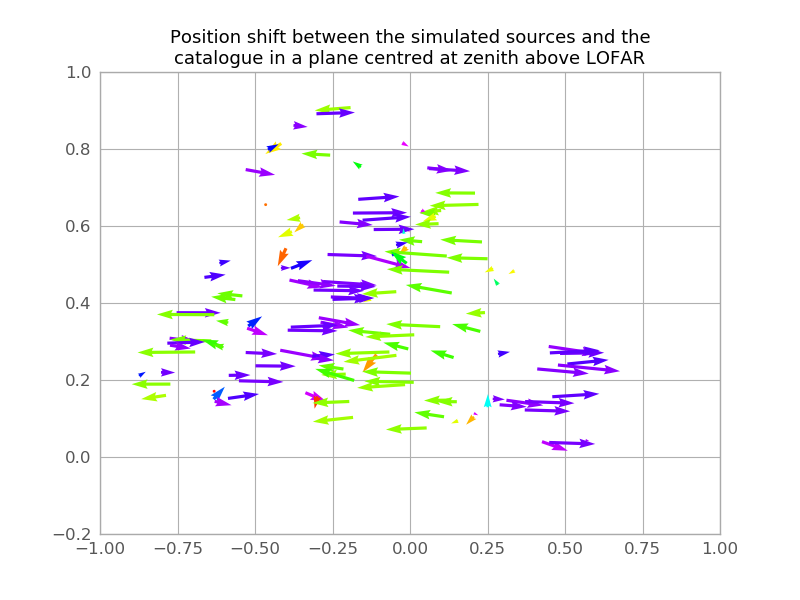

In [19]:
%matplotlib notebook
from matplotlib.colors import Normalize
from textwrap import wrap
fig, ax = plt.subplots()

ax.quiver(ace_cartesian.x, ace_cartesian.y, Diff_X, Diff_Y, np.arctan2(Diff_X,Diff_Y),cmap='hsv',norm=Normalize(-np.pi,np.pi))
ax.axis([-1,1,-0.2,1])
title = ax.set_title("\n".join(wrap('Position shift between the simulated sources and the catalogue in a plane centred at zenith above LOFAR', 60)), fontdict={'fontsize': 13, 'fontweight': 'medium'})
title.set_y(1.0)
plt.show()
plt.savefig('position_shift_simulation.png', dpi=200)